In [1]:
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

C:\Users\Hp\AppData\Local\Temp\ipykernel_24404\1227116357.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# Limiting tensorflow from using all the memory that can cause OOM error
gpus = tf.config.experimental.list_physical_devices("GPU")
gpus

[]

In [3]:
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Removing Doggy Images  

In [4]:
data__dir = "Data"

In [5]:
image_exts = ['jpg', "png", "jpeg", "bmp"]

In [6]:
image_exts

['jpg', 'png', 'jpeg', 'bmp']

In [7]:
for image_class in os.listdir(data__dir):
  for image in os.listdir(os.path.join(data__dir, image_class)):
    image_path = os.path.join(data__dir, image_class,image)
    try:
      img = cv2.imread(image_path)
      if img is None:
              print(f"Unreadable image (corrupted): {image_path}")
              os.remove(image_path)
              continue
      tip = imghdr.what(image_path)

      if tip not in image_exts:
        print("Image not in ext list {}".format(image_path))
        os.remove(image_path)

    except Exception as e:
      print("Issue with image {}".format(image_path))

## Loading data

In [8]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [9]:
data = tf.keras.utils.image_dataset_from_directory("Data")

Found 178 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

In [12]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

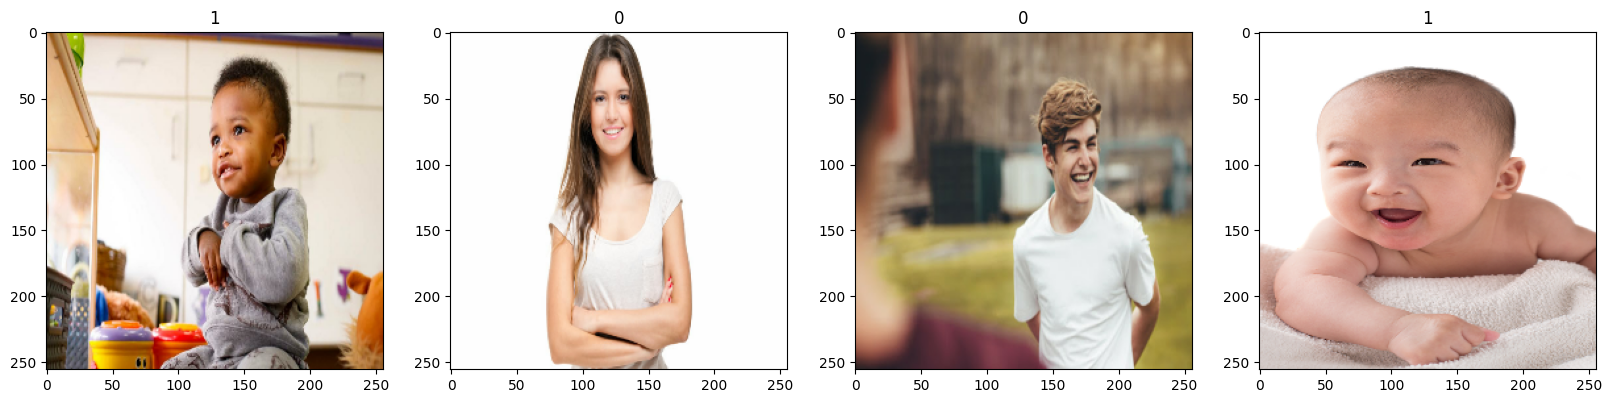

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])


## 2. Preprocessing data
### 2.1 Scale data

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()[0].min()

np.float32(0.0)

### 2.2 Split Data



In [16]:
len(data)

6

In [17]:
train_size = int(len(data) *0.7)
val_size = int(len(data)*.2)
test_size = int (len(data) *.1)+1

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Validation size: {val_size} ")

Train size: 4
Test size: 1
Validation size: 1 


In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [19]:
len(train)

4

## Deep model
### Build a deep learning model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [21]:
model =  Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 3, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


g:\Deep Learning Projects\Deep-CNN-Image-Classifier\imageclassification\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,825 (1.60 MB)

 Trainable params: 419,825 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [25]:
logdir = 'logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 862ms/step - accuracy: 0.5021 - loss: 0.7070 - val_accuracy: 0.6562 - val_loss: 0.6758
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - accuracy: 0.7385 - loss: 0.6577 - val_accuracy: 0.6875 - val_loss: 0.6163
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 871ms/step - accuracy: 0.6698 - loss: 0.6334 - val_accuracy: 0.7812 - val_loss: 0.5827
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 769ms/step - accuracy: 0.6948 - loss: 0.5982 - val_accuracy: 0.8438 - val_loss: 0.4926
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 957ms/step - accuracy: 0.6729 - loss: 0.5873 - val_accuracy: 0.6250 - val_loss: 0.6032
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 0.7469 - loss: 0.5377 - val_accuracy: 0.7812 - val_loss: 0.4901
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step - accuracy: 0.8062 - loss: 0.4796 - val_accuracy: 0.7812 - val_loss: 0.4549
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 760ms/step - accuracy: 0.7667 - loss: 0.4866 - val_accuracy: 0.8750 - val_loss:

### Plot performance

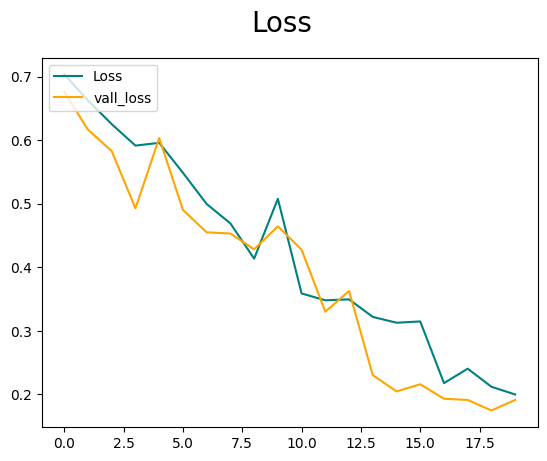

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'Loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'vall_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

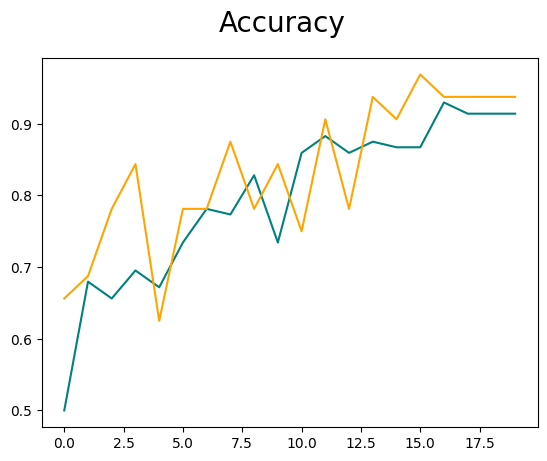

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = "Accuracy")
plt.plot(hist.history['val_accuracy'], color = "orange", label ="Val_accuracy")
fig.suptitle("Accuracy", fontsize = 20)
plt.show()

## Evaluate Performance

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
bac = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator():
  X,y = batch
  y_pred = model.predict(X)
  pre.update_state(y, y_pred)
  re.update_state(y,y_pred)
  bac.update_state(y,y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


In [36]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, BinaryAccuracy {bac.result().numpy()}")  

Precision: 1.0, Recall: 0.8571428656578064, BinaryAccuracy 0.9444444179534912
